In [1]:
###initialize imports and dataset
import math
import numpy as np
import pandas as pd
import deepchem as dc
from deepchem.utils.save import load_from_disk
from deepchem.data import data_loader
import random
random.seed(0)
import pickle
import matplotlib.pyplot as plt

dataset_file = "./enamineSubset10KGroundTruth.csv"
ground_truth_dataset = load_from_disk(dataset_file) #pandas Dataframe

low_bace_dataset = ground_truth_dataset.sort_values(by="bace")[:2500] #take 2.5K worst binder potential starters,shouldn't need copy

top_5_percent_index = len(ground_truth_dataset) // 20
top_5_percent_bace_cutoff = ground_truth_dataset.sort_values(by="bace", ascending=True,)["bace"][top_5_percent_index]

print("Cutoff bace score for 95th percentile:", top_5_percent_bace_cutoff)
print("Columns of dataset: %s" % str(ground_truth_dataset.columns.values))
print("Number of examples in dataset: %s" % str(ground_truth_dataset.shape[0]))

Cutoff bace score for 95th percentile: 4.870083
Columns of dataset: ['Index' 'SMILES' 'bace' 'esol' 'logD']
Number of examples in dataset: 10000


In [2]:
###initialize ground truth models and methods to access them

def load_oracle_models():
    """Loads the pretrained ground truth models for evaluating molecules' properties on-the-fly.
    
    Returns
    -------
    oracle : dict
        A dictionary containing models mapped to their property keywords: "bace", "esol", "logD".
    """
    bace_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/bace")
    esol_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/esol")
    logD_model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/logD")
    bace_model.restore()
    esol_model.restore()
    logD_model.restore()
    oracle = {"bace":bace_model, "esol":esol_model, "logD":logD_model} #get each model via the named property
    return oracle

def query_oracle(dataset, oracle):
    """Evaluate molecules on-the-fly for their estimated bace, esol, and logD scores.
    
    Parameters
    ----------
    dataset : pandas.DataFrame
        The input dataset; must includes a field with smiles strings under keyword "SMILES".
    oracle : dictionary( dc.models.GraphConvModel )
        The pretrained ground truth value prediction models.
        
    Returns
    -------
    results : pandas.DataFrame
        Copy of input dataset with newly estimated bace, esol, and logD scores under those headers. 
    """
    query_file = "./temp/oracle_eval.csv"
    dataset.to_csv(query_file)
    
    results = dataset.copy(deep=True) #defensive copy of input dataframe 
    
    featurizer = dc.feat.ConvMolFeaturizer()
    for prop in ("bace", "esol", "logD"):
        #retrieve appropriate model from oracle
        model = oracle[prop]
        
        #load, featurize, and normalize input dataset
        loader = dc.data.CSVLoader(tasks=[prop], smiles_field="SMILES",featurizer=featurizer)
        dataset_feat = loader.featurize(query_file)
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)
        
        #predict and assign property results to keyword
        predicted = model.predict(dataset_feat)
        results[prop] = predicted
        
    return results

In [92]:
###define Abstract Data Type to hold search information, including ensemble

class Experimenter():
    """Class representing a research scientist/team going through the drug development process.
    
    Parameters
    ----------
    N : int
        Number of samples to initially train the experimenter ensemble on.
    M : int
        Number of molecules to purchase in each batch.
    ensemble_size : int, optional
        Number of models in experimenter ensemble.
    epochs : int, optional
        Number of epochs to train ensemble models for at each stage.
    molecule_cost : int or float, optional
        Monetary cost of purchasing a single molecule.
    target_bounds : dictionary of str:tuples(floats), optional
        Desired range for each property.
    
    Attributes
    ----------
    ensemble : dictionary of deepchem.models.GrachConvModel
        Models representing the experimenter knowledge/predictions and uncertainty.
    history : list of <NEEDS IMPLEMENTING>
        Snapshots of the model state at each time step.
    samples_seen : pandas.DataFrame
        All of the molecules seen before. Includes initial training set.
    smiles_seen : list of str
        SMILES strings of the molecules seen before.
    cost : int or float
        Total monetary cost incurred at the current time.
    number_molecules : int
        Total number of molecules purchased at the current time.
    time : int
        Total number of days spent up to the current time.
        
    """
    def __init__(self, N, M, ensemble_size=3, epochs=1, molecule_cost=200,
                 target_bounds={"bace":(4, math.inf), "esol":(-5, math.inf), "logD":(-0.4, 5.6)} ):
        self.N = N #initial samples
        self.M = M #batch size
        self.ensemble_size = ensemble_size
        self.epochs = epochs
        self.molecule_cost = molecule_cost
        self.target_bounds = target_bounds
        
        self.ensemble = {i:dc.models.GraphConvModel(n_tasks=3, mode='regression', batch_size=20, random_seed=i) 
                         for i in range(self.ensemble_size)} #map each model to its seed
        self.history = [] #save snapshot of model, on disk
        self.samples_seen = None
        self.smiles_seen = []
        self.cost = 0
        self.number_molecules = 0
        self.time = 0 #days
        
        
    def train_model(self, model, dataset):
        """Helper function to train a given ensemble model on a given dataset.
        
        Parameters
        ----------
        model : Keras model (generally deepchem.GraphConvModel)
            Model to be trained.
        dataset : pandas.DataFrame
            Dataset to train on. Must include "SMILES", "bace", "esol", and "logD" headers.
            
        """
        #convert DataFrame to CSV and read in as deepchem.Dataset via deepchem.CSVLoader
        dataset_temp_file = "./temp/training_dataset.csv"
        dataset.to_csv(dataset_temp_file)

        featurizer = dc.feat.ConvMolFeaturizer()
        loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)

        dataset_feat = loader.featurize(dataset_temp_file)

        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)

        model.fit(dataset_feat, nb_epoch=1, deterministic=True, restore=False)
    
    
    def train_ensemble(self, dataset):
        """Helper function to train model ensemble.
        
        Parameters
        ----------
        dataset : pandas.Dataset
            Dataset on which to train models. Must include "SMILES", "bace", "esol", and "logD" headers.
        
        """
        for model in self.ensemble.values():
            self.train_model(model, dataset)

    
    def initial_training(self, verbose=False):
        """Train model ensemble for the first time on self.N samples randomly chosen from the 2500 lowest bace affinity-scored 
        molecules.
        
        Parameters
        ----------
        verbose : bool
            Whether to print progress updates.
        
        Notes
        -----
        If self.N > 2500, ensemble will be trained on 2500 samples.
        Records first history object.
        
        """
        idx_range = self.N if self.N < low_bace_dataset.shape[0] else low_bace_dataset.shape[0]
        rand_indices = random.sample(range(low_bace_dataset.shape[0]), k=idx_range) #select random row indices
        
        init_ensemble_dataset = pd.DataFrame()
        for idx in rand_indices:
            init_ensemble_dataset = init_ensemble_dataset.append( low_bace_dataset.iloc[idx], ignore_index=True )
        
        if verbose:
            print("Training set selected.")
            
        self.samples_seen = init_ensemble_dataset ### collect the examples seen during initial training
        self.smiles_seen = init_ensemble_dataset["SMILES"].tolist()
        
        #cost/time to initially train? free initial knowledge?
        self.cost += 200 * len(init_ensemble_dataset)
        self.number_molecules += len(init_ensemble_dataset)
        self.time = 0
        
        if verbose:
            print("Training ensemble...")
            
        self.train_ensemble(init_ensemble_dataset) #train ensemble on initial dataset
        
        self.record_history()
        
        if verbose:
            print("Ensemble trained.")
        
        
    ###get_component_score, ket/list(keys)
    def get_component_score(self, arr, keys):
        """Helper function to get the scaled "goodness" of the input scores.
        
        Parameters
        ----------
        array : numpy.array
             Array with bace, esol, and logD scores.
        keys : collection of strings from {"bace", "esol", "logD"}
            Which scores to incorporate into the overall goodness.
        
        Returns
        -------
        numpy.array
            Sum of component scores.
        
        """
        scores = []
        if "bace" in keys:
            #higher bace => higher score
            bace = arr[:,0]
            bace_range = self.target_bounds["bace"]
            scores.append( np.where(bace < bace_range[0], 0.2*bace-0.8, 0.05*bace-0.2) )
            #dec penalty when score>low end of range
        
        if "esol" in keys:
            esol = arr[:,1]
            esol_range = self.target_bounds["esol"]
            scores.append( np.where(esol < esol_range[0], esol - np.absolute(esol-esol_range[1])**2, esol) )
        
        if "logD" in keys:
            #logD within range is not penalized
            logD = arr[:,2]
            logD_range = self.target_bounds["logD"]
            #handle lower end of range
            int_arr = np.where(logD < logD_range[0], logD - np.absolute(logD-logD_range[0]), logD)
            #handle upper end of range
            scores.append(np.where(int_arr > logD_range[1], int_arr - np.absolute(int_arr-logD_range[1]), int_arr) )

        return sum(scores)
        
    
    def score_and_select_top(self):
        """Scores all molecules and selects the top M for "purchase".
        
        """
        featurizer = dc.feat.ConvMolFeaturizer()
        loader = dc.data.CSVLoader(tasks=["bace", "esol", "logD"], smiles_field="SMILES", featurizer=featurizer)
        dataset_feat = loader.featurize(dataset_file) #featurize the molecules from the ground truth dataset
        transformer = dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset_feat)
        dataset_feat = transformer.transform(dataset_feat)
        
        predicted = np.zeros( (len(dataset_feat),3) )
        for model in self.ensemble.values():
            predicted += model.predict(dataset_feat)
        predicted /= len(self.ensemble) #take the average of model predictions
        
        #copy SMILES and assign/calculate scores
        results_df = pd.DataFrame()
        results_df["SMILES"] = ground_truth_dataset["SMILES"]   

        goodness = self.get_component_score(predicted, ["bace", "esol", "logD"])
        results_df["bace"] = predicted[:,0]
        results_df["esol"] = predicted[:,1]
        results_df["logD"] = predicted[:,2]
        results_df["goodness"] = goodness
        
        unseen_rows = results_df.loc[~results_df['SMILES'].isin(self.smiles_seen)] #remove examples previously seen
        unseen_rows = unseen_rows.sort_values(by="goodness", ascending=False) #sort with highest goodness at top
        
        subset = unseen_rows[:self.M] if len(unseen_rows) > self.M else unseen_rows #select up to self.M samples
        
        self.samples_seen = pd.concat([self.samples_seen,subset], sort=False)
        self.smiles_seen = self.samples_seen["SMILES"].tolist()
        #self.samples_seen = self.samples_seen.append(subset, sort=False) # ignore_index=True?
        
        self.cost += 200 * len(subset)
        self.number_molecules += len(subset)
            
        self.time += 28 #4 weeks to buy and experiment
        
    
    def record_history(self):
        """Stores model costs and experience for later analysis.
        
        Notes
        -----
        Does not save self.history attribute, in order to avoid redundantly storing the data in it.
        Only saves attributes that change in each time step.
        
        """
        hist = {}
        hist["samples_seen"] = self.samples_seen
        hist["smiles_seen"] = self.smiles_seen
        hist["cost"] = self.cost
        hist["number_molecules"] = self.number_molecules
        hist["time"] = self.time
        self.history.append(hist)
     

    def run(self):
        """Simple wrapper to automate calls to select molecules and update models. 
        
        Notes
        -----
        Must be preceded by initial training of model ensemble.
        
        """        
        while len(self.samples_seen) < len(ground_truth_dataset): #replace with top bace score to exit -> 4.87(approx 95th %ile)
            candidates = self.samples_seen.loc[self.samples_seen['bace'] >= top_5_percent_bace_cutoff] #find mols w/ high bace
            
            esol_lower_bound = self.target_bounds["esol"][0]
            candidates = candidates.loc[candidates['esol'] >= esol_lower_bound] #filter the insoluble mols
            
            logD_range = self.target_bounds["logD"]
            candidates = candidates.loc[( candidates['logD'] >= logD_range[0] ) 
                                                 & ( candidates['logD'] <= logD_range[1] )] #filter for logD in range
              
            if len(candidates) > 0:
                print("Molecule within bounds and 95th percentile bace affinity found.")
                return candidates
                
            self.score_and_select_top()
            self.record_history()
            self.train_ensemble(self.samples_seen)

In [ ]:
"""
Step 1: load ground truth models and ensemble

Step 2: train ensemble on N random data points (including ground truth values)

Step 3: score all of the 10K molecules using the ensemble

Step 4: take ("buy") the top M, and "assess them experimentally" (get their ground truth values)

Step 5: add those samples to the training/seen set

Step 6: retrain the ensemble

Step 7: repeat (make 2-6 repeatable)

Step 8: add some loops over N and M to generate plots of Hx vs N,M
"""

In [93]:
#N = [96, 384, 1536] #initial train set size
N = [96]
#M = [96, 384, 1536] #batch size -> 96 wells, multiples
M = [96]

models = []

for n in N:
    for m in M:
        e = Experimenter(n, m, ensemble_size=1)
        models.append(e)
        e.initial_training()
        top_mols = e.run()

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./temp/training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.142 s
TIMING: dataset construction took 0.276 s
Loading dataset from disk.
TIMING: dataset construction took 0.128 s
Loading dataset from disk.


C:\Users\darne\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 5: Average loss 1.15469
TIMING: model fitting took 36.656 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./enamineSubset10KGroundTruth.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 15.056 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 2.762 s
TIMING: dataset construction took 22.810 s
Loading dataset from disk.
TIMING: dataset construction took 9.095 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./temp/training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.283 s
TIMING: dataset construction took 0.445 s
Loading dataset from disk.
TIMING: da

Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 3.093 s
TIMING: dataset construction took 25.370 s
Loading dataset from disk.
TIMING: dataset construction took 10.525 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./temp/training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.851 s
TIMING: dataset construction took 2.389 s
Loading dataset from disk.
TIMING: dataset construction took 0.877 s
Loading dataset from disk.
Ending global_step 220: Average loss 1.1813
TIMING: model fitting took 13.230 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./enamineSubset10KGroundTruth.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featu

TIMING: model fitting took 18.755 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./enamineSubset10KGroundTruth.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 16.000 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 2.814 s
TIMING: dataset construction took 24.617 s
Loading dataset from disk.
TIMING: dataset construction took 8.602 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./temp/training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.464 s
TIMING: dataset construction took 4.250 s
Loading dataset from disk.
TIMING: dataset construction 

Featurizing sample 1000
TIMING: featurizing shard 1 took 2.823 s
TIMING: dataset construction took 25.548 s
Loading dataset from disk.
TIMING: dataset construction took 11.976 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./temp/training_dataset.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
TIMING: featurizing shard 0 took 4.768 s
TIMING: dataset construction took 5.854 s
Loading dataset from disk.
TIMING: dataset construction took 2.009 s
Loading dataset from disk.
Ending global_step 1450: Average loss 1.26441
TIMING: model fitting took 27.815 s
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./enamineSubset10KGroundTruth.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featur

KeyboardInterrupt: 

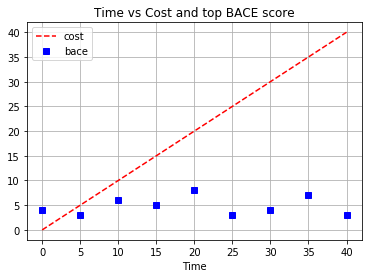

In [88]:
import matplotlib.pyplot as plt

for model in models:
    costs = []
    times = []
    top_bace_scores = []
    for hx in model.history:
        costs.append(hx["cost"])
        times.append(hx["time"])
        top_bace_scores.append(hx["samples_seen"]["bace"].max())

        plt.plot(times,costs,'r--',label="cost")
        plt.plot(times,top_bace_scores,'bs',label="bace")
        plt.xlabel('Time')
        plt.title(r'Time vs Cost and top BACE score')
        plt.grid(True)
        plt.legend()
        plt.show()